# Segmenting customers by RFM Score

The purpose of this notebook is to use K-Means Clustering to segment a customer base in 3 groups based on their RFM Score.


## RFM

The RFM Score (Recency, Frequency, Monetary Value) is a metric that analyzes the customer based on three data points:

- **Recency**: How recently the customer made a purchase
- **Frequency**: How often do they purchase
- **Monetary Value**: How much they spent

RFM analysis classifies customers with a numerical ranking of the three categories, with the ideal customer earning the highest on each category.


## The Data

The dataset contains about three years worth of anonymized transactions from a Brazilian tech retail store.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# K-Means to cluster the users
from sklearn.cluster import KMeans

# Yellowbrick for model visualization
from yellowbrick.cluster import KElbowVisualizer

In [2]:
# Define the functions
def order_clusters(cluster, target, df, ascending):
    new_cluster = 'new' + cluster
    
    temp = df.groupby(cluster)[target].mean().reset_index()
    temp = temp.sort_values(by=target, ascending=ascending).reset_index(drop=True)
    temp['index'] = temp.index
    
    cluster_df = pd.merge(df, temp[[cluster, 'index']], on=cluster)
    cluster_df = cluster_df.drop([cluster], axis=1)
    cluster_df = cluster_df.rename(columns={'index':cluster})
    
    return cluster_df

def rfm_cluster(df, cluster_variable, n_clusters, ascending):
    
    # Create and fit the k-means 
    model = KMeans(n_clusters=n_clusters)
    model.fit(df[[cluster_variable]])
    
    # predict the cluster and pass it to the dataframe
    df[cluster_variable + 'Cluster'] = model.predict(df[[cluster_variable]])
    
    # order the cluster numbers
    df = order_clusters(cluster_variable + 'Cluster', cluster_variable, df, ascending)
    
    return df

In [4]:
df = pd.read_csv('data/ecommerce tech retail - 2018 a 2020.csv')

In [30]:
# df = df[(df['Date'] > '2019-06-15') & (df['Date'] < '2020-06-15')]

In [5]:
df.head()

,Date,Client ID,Transaction ID,Transactions,Transaction revenue,Item revenue,Item quantity,Transaction shipping,Items per purchase
0,2018-01-01,531.543.711.514.850.000,100493910,1,"80,91","89,9",1,0,1
1,2018-01-01,1.380.362.241.514.800.000,100493895,1,"531,73",499,1,"72,75",1
2,2018-01-01,2.096.043.641.509.890.000,100493894,1,399,399,1,0,1
3,2018-01-01,4.598.890.021.514.840.000,100493907,1,"1024,07",999,1,"25,07",1
4,2018-01-01,13.577.253.201.514.800.000,100493903,1,"185,07",199,1,0,1


In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
# Replace the commas with points
df['Transaction revenue'] = df['Transaction revenue'].str.replace(',', '.')
df['Transaction shipping'] = df['Transaction shipping'].str.replace(',', '.')

In [8]:
# Convert to numeric
df['Transaction revenue'] = pd.to_numeric(df['Transaction revenue'])
df['Transaction shipping'] = pd.to_numeric(df['Transaction shipping'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40576 entries, 0 to 40575
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  40576 non-null  datetime64[ns]
 1   Client ID             40576 non-null  object        
 2   Transaction ID        40576 non-null  int64         
 3   Transactions          40576 non-null  int64         
 4   Transaction revenue   40576 non-null  float64       
 5   Item revenue          40576 non-null  object        
 6   Item quantity         40576 non-null  int64         
 7   Transaction shipping  40576 non-null  float64       
 8   Items per purchase    40576 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 2.8+ MB


In [10]:
# define and check a few metrics about the dataset
maxdate = df['Date'].dt.date.max()
mindate = df['Date'].dt.date.min()
total_customers = df['Client ID'].count()
unique_customers = df['Client ID'].nunique()
quantity = df['Item quantity'].sum()
revenue = df['Transaction revenue'].sum()

print(f'Total customers: {total_customers}')
print(f'Unique customers: {unique_customers}')
print(f'Quantity sold: {quantity}')
print(f'Revenue: {revenue}')

Total customers: 40576
Unique customers: 30842
Quantity sold: 65548
Revenue: 45976465.18


In [11]:
# Create the users dataframe
users = pd.DataFrame(df['Client ID'].unique())
users.columns = ['Client ID']
users

,Client ID
0,531.543.711.514.850.000
1,1.380.362.241.514.800.000
2,2.096.043.641.509.890.000
3,4.598.890.021.514.840.000
4,13.577.253.201.514.800.000
...,...
30837,17.074.155.721.590.600.000
30838,18.118.606.781.591.500.000
30839,18.557.209.511.591.500.000
30840,19.034.703.911.591.300.000


# Calculating Recency
   > Recency describes in days how recently a customer made a purchase

In [12]:
# Get the latest purchase date for each client and pass it to a df
latest_purchase = df.groupby('Client ID').Date.max().reset_index()
latest_purchase.columns = ['Client ID', 'LatestPurchaseDate']
latest_purchase['LatestPurchaseDate'] = latest_purchase['LatestPurchaseDate'].dt.date

# Calculate Recency
latest_purchase['Recency'] = (latest_purchase['LatestPurchaseDate'].max() - latest_purchase['LatestPurchaseDate']).dt.days

# Merge the dataframes
users = pd.merge(users, latest_purchase[['Client ID', 'Recency']], on='Client ID')
users.head()

,Client ID,Recency
0,531.543.711.514.850.000,888
1,1.380.362.241.514.800.000,888
2,2.096.043.641.509.890.000,878
3,4.598.890.021.514.840.000,888
4,13.577.253.201.514.800.000,888


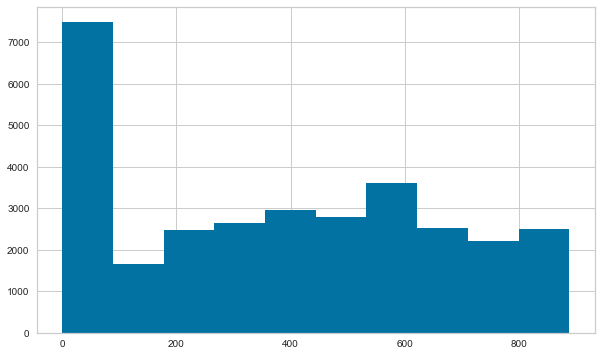

In [13]:
# Plot the distribution of Recency
fig = plt.figure(figsize=(10, 6))
plt.hist(users['Recency']);

We can see that the majority of purchases were very recent compared to the entire range of the dataset.

In [15]:
users['Recency'].describe()

count    30842.000000
mean       385.439433
std        273.825349
min          0.000000
25%        100.000000
50%        389.000000
75%        605.000000
max        888.000000
Name: Recency, dtype: float64

# Frequency
> Frequency indicates how oftenly a customers makes a purchase

In [17]:
# Create the frequency df
frequency = df.groupby('Client ID')['Date'].count().reset_index()
frequency.columns = ['Client ID', 'Frequency']

In [18]:
# Merge with the users df
users = pd.merge(users, frequency, on='Client ID')
users.head()

,Client ID,Recency,Frequency
0,531.543.711.514.850.000,888,1
1,1.380.362.241.514.800.000,888,1
2,2.096.043.641.509.890.000,878,2
3,4.598.890.021.514.840.000,888,1
4,13.577.253.201.514.800.000,888,1


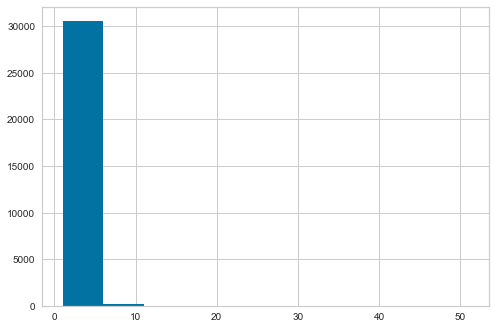

In [19]:
plt.hist(users['Frequency']);

The vast amount of customers makes less than 10 purchases on the ecommerce. This is terrible customer retention and can be due to myriad of reasons: bigger competitors entering the Brazilian market (e.g. Amazon), poor customer service, bad marketing strategies etc.

In [20]:
users['Frequency'].describe()

count    30842.000000
mean         1.315609
std          1.136794
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         51.000000
Name: Frequency, dtype: float64

At least 75% of the clients have only bought once from the store.

# Monetary Value (Revenue)
> How much money a customer has spent on purchases

In [21]:
# Calculate revenue for each individual customer
revenue = df.groupby('Client ID')['Transaction revenue'].sum().reset_index()

In [22]:
revenue.head()

,Client ID,Transaction revenue
0,1.000.181.311.588.320.000,998.00
1,1.000.546.241.572.000.000,348.78
2,1.004.431.231.540.770.000,999.00
3,1.004.875.601.549.710.000,2098.00
4,1.006.786.651.535.540.000,2157.84


In [23]:
# Merge with the users df
users = pd.merge(revenue, users, on='Client ID')

In [24]:
users.columns = ['Client ID', 'Revenue', 'Recency', 'Frequency']
users.head()

,Client ID,Revenue,Recency,Frequency
0,1.000.181.311.588.320.000,998.00,37,1
1,1.000.546.241.572.000.000,348.78,226,2
2,1.004.431.231.540.770.000,999.00,588,1
3,1.004.875.601.549.710.000,2098.00,484,2
4,1.006.786.651.535.540.000,2157.84,648,2


# Calculate the time between purchases

In [26]:
df['Days between purchases'] = np.around((df['Date'] - df['Date'].min()) / np.timedelta64(len(users), 'D'))

In [27]:
time_between_purchases = df.groupby('Client ID')['Days between purchases'].mean().reset_index()

In [28]:
users = pd.merge(time_between_purchases, users, on='Client ID')

In [29]:
users.head()

,Client ID,Days between purchases,Revenue,Recency,Frequency
0,1.000.181.311.588.320.000,0.0,998.00,37,1
1,1.000.546.241.572.000.000,0.0,348.78,226,2
2,1.004.431.231.540.770.000,0.0,999.00,588,1
3,1.004.875.601.549.710.000,0.0,2098.00,484,2
4,1.006.786.651.535.540.000,0.0,2157.84,648,2


In [30]:
# export the df to a csv file
users.to_csv('users_data.csv', index=False, header=['ID do Cliente','Dias entre compras', 'Receita Total do Cliente', 'Dias desde a última compra', 'Quantidade de vezes que o cliente comprou'])

# Creating the clusters

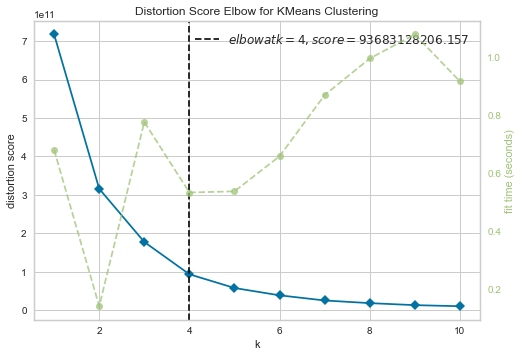

In [31]:
model = KMeans()

revenue_score = users[['Revenue']]

visualizer = KElbowVisualizer(model, k=(1, 11))

visualizer.fit(revenue_score)
visualizer.show();

The optimum amount of clusters is 4

# Recency Cluster

In [32]:
users = rfm_cluster(users, 'Recency', 4, False)

users.head()

,Client ID,Days between purchases,Revenue,Recency,Frequency,RecencyCluster
0,1.000.181.311.588.320.000,0.0,998.00,37,1,3
1,1.007.647.271.568.850.000,0.0,3799.00,42,1,3
2,1.011.452.831.583.090.000,0.0,2434.89,95,1,3
3,1.012.919.581.587.220.000,0.0,179.80,50,1,3
4,1.018.704.401.586.450.000,0.0,1708.10,59,1,3


In [33]:
users.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,6481.0,768.154297,68.413866,650.0,704.0,774.0,829.0,888.0
1,8012.0,533.519096,63.789296,416.0,481.0,542.0,579.0,649.0
2,7269.0,299.323841,70.168866,175.0,236.0,304.0,361.0,415.0
3,9080.0,50.547907,42.690905,0.0,16.0,41.0,68.0,174.0


# Monetary Value (Revenue) Cluster

In [34]:
users = rfm_cluster(users, 'Revenue', 4, True)
users.head()

,Client ID,Days between purchases,Revenue,Recency,Frequency,RecencyCluster,RevenueCluster
0,1.000.181.311.588.320.000,0.0,998.00,37,1,3,0
1,1.007.647.271.568.850.000,0.0,3799.00,42,1,3,0
2,1.011.452.831.583.090.000,0.0,2434.89,95,1,3,0
3,1.012.919.581.587.220.000,0.0,179.80,50,1,3,0
4,1.018.704.401.586.450.000,0.0,1708.10,59,1,3,0


In [35]:
users.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,28817.0,944.900513,992.192048,1.71,197.2900,568.05,1389.6000,4446.00
1,1986.0,7970.660645,4427.749310,4463.10,5102.5300,6483.85,8992.0425,33271.89
2,38.0,60067.692105,26665.760303,34952.50,40216.4175,51334.25,64104.5550,127960.05
3,1.0,634962.770000,NaN,634962.77,634962.7700,634962.77,634962.7700,634962.77


# Frequency Cluster

In [40]:
# Create the Frequency Clusters
users = rfm_cluster(users,'Frequency', 4, True)

# describe the clusters
users.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,25387.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
1,5006.0,2.347982,0.616103,2.0,2.0,2.0,3.00,4.0
2,431.0,6.825986,2.466496,5.0,5.0,6.0,8.00,17.0
3,18.0,27.388889,11.251870,18.0,20.0,22.0,31.25,51.0


# Overall RFM Score
> For this particular RFM model, all the features will have the same weight, but this can easily be ajusted in the formula below

In [42]:
# Calculate OverallScore
users['OverallScore'] = users['FrequencyCluster'] + users['RevenueCluster'] - users['RecencyCluster'] 

# Show the mean of the features for each OverallScore value
users.groupby('OverallScore')[['Recency', 'Frequency', 'Revenue']].mean()

,Recency,Frequency,Revenue
OverallScore,,,
-3,51.723017,1.000000,758.597929
-2,261.556547,1.145407,1016.639891
-1,483.476772,1.233209,1317.300098
0,695.141947,1.342866,1534.266102
1,685.592503,2.640871,4391.993930
2,695.662857,4.520000,11199.602171
3,738.386667,7.973333,16376.219200
4,675.090909,19.090909,48371.509091
5,727.000000,26.000000,50495.805000


We can arbitrarily assign labels for the different Overall Score clusters for the sake of simplicity

| Value   | Label  |
|---------|--------|
| (-3,-1) | Low    |
| (0,2)   | Medium |
| (3,5)   | High   |

In [44]:
# Create the Segment variable based on the OverallScore
x = users['OverallScore']
conditions = [x<0, x<3]
choices = ['Low', 'Medium']

users['Segment'] = np.select(conditions, choices, default='High')

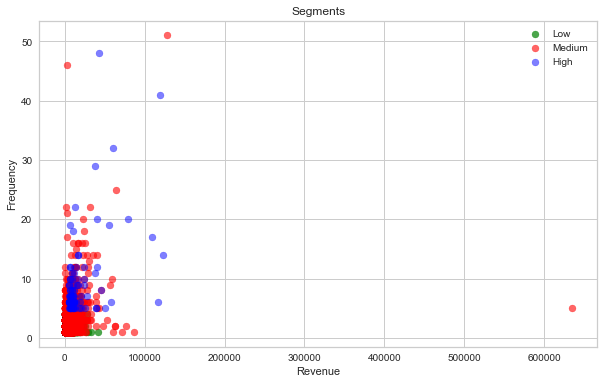

In [45]:
fig = plt.figure(figsize=(10, 6))
plt.title('Segments')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
    
plt.scatter(x=users.query("Segment == 'Low'")['Revenue'],
            y= users.query("Segment == 'Low'")['Frequency'],
            c='green', alpha=0.7, label='Low')

plt.scatter(x=users.query("Segment == 'Medium'")['Revenue'],
            y=users.query("Segment == 'Medium'")['Frequency'],
            c='red', alpha=0.6, label='Medium')

plt.scatter(x=users.query("Segment == 'High'")['Revenue'],
            y=users.query("Segment == 'High'")['Frequency'],
            c='blue', alpha=0.5, label='High')

plt.legend();

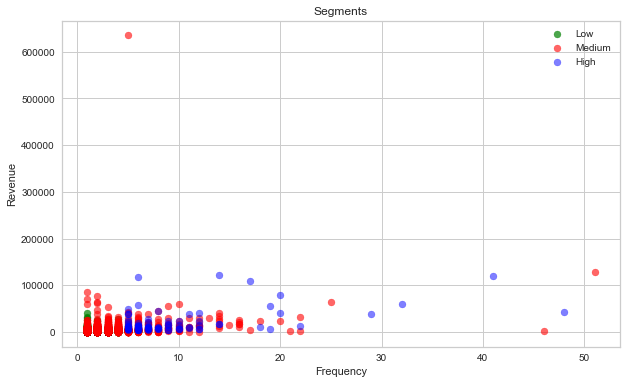

In [46]:
fig = plt.figure(figsize=(10, 6))
plt.title('Segments')
plt.xlabel('Frequency')
plt.ylabel('Revenue')
    
plt.scatter(x=users.query("Segment == 'Low'")['Frequency'],
            y= users.query("Segment == 'Low'")['Revenue'],
            c='green', alpha=0.7, label='Low')

plt.scatter(x=users.query("Segment == 'Medium'")['Frequency'],
            y=users.query("Segment == 'Medium'")['Revenue'],
            c='red', alpha=0.6, label='Medium')

plt.scatter(x=users.query("Segment == 'High'")['Frequency'],
            y=users.query("Segment == 'High'")['Revenue'],
            c='blue', alpha=0.5, label='High')

plt.legend();

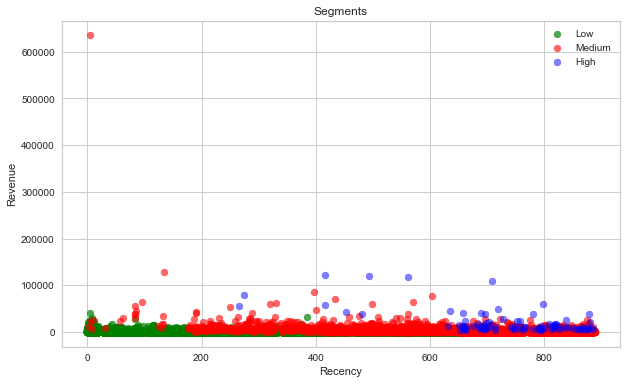

In [47]:
fig = plt.figure(figsize=(10, 6))
plt.title('Segments')
plt.xlabel('Recency')
plt.ylabel('Revenue')

plt.scatter(x=users.query("Segment == 'Low'")['Recency'],
            y= users.query("Segment == 'Low'")['Revenue'],
            c='green', alpha=0.7, label='Low')

plt.scatter(x=users.query("Segment == 'Medium'")['Recency'],
            y=users.query("Segment == 'Medium'")['Revenue'],
            c='red', alpha=0.6, label='Medium')

plt.scatter(x=users.query("Segment == 'High'")['Recency'],
            y=users.query("Segment == 'High'")['Revenue'],
            c='blue', alpha=0.5, label='High')

plt.legend();

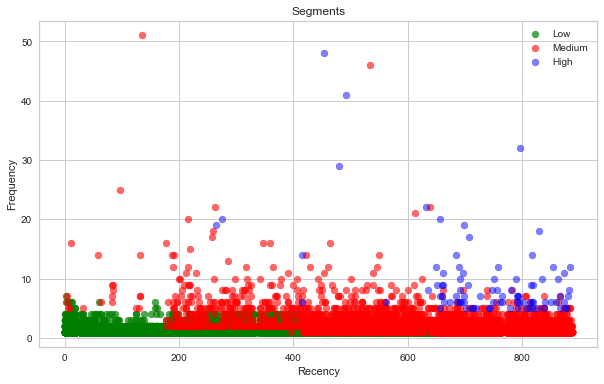

In [48]:
fig = plt.figure(figsize=(10, 6))
plt.title('Segments')
plt.xlabel('Recency')
plt.ylabel('Frequency')
    
plt.scatter(x=users.query("Segment == 'Low'")['Recency'],
            y= users.query("Segment == 'Low'")['Frequency'],
            c='green', alpha=0.7, label='Low')

plt.scatter(x=users.query("Segment == 'Medium'")['Recency'],
            y=users.query("Segment == 'Medium'")['Frequency'],
            c='red', alpha=0.6, label='Medium')

plt.scatter(x=users.query("Segment == 'High'")['Recency'],
            y=users.query("Segment == 'High'")['Frequency'],
            c='blue', alpha=0.5, label='High')

plt.legend();

We can see the segments behave differently so we can apply adequate marketing strategies to the each group.

In [49]:
users.head()

,Client ID,Days between purchases,Revenue,Recency,Frequency,RecencyCluster,RevenueCluster,FrequencyCluster,OverallScore,Segment
0,1.000.181.311.588.320.000,0.0,998.00,37,1,3,0,0,-3,Low
1,1.007.647.271.568.850.000,0.0,3799.00,42,1,3,0,0,-3,Low
2,1.011.452.831.583.090.000,0.0,2434.89,95,1,3,0,0,-3,Low
3,1.012.919.581.587.220.000,0.0,179.80,50,1,3,0,0,-3,Low
4,1.018.704.401.586.450.000,0.0,1708.10,59,1,3,0,0,-3,Low
